In [1]:
import nibabel as nib
import numpy as np

# 讀取 NIfTI 檔案
file_path = '/NFS/Wu/MRI/hw2/output_dir_W/IXI002-Guys-0828-T1_wmh.nii.gz' 
img = nib.load(file_path)

# 獲取體素數據
data = img.get_fdata()

# 獲取體素尺寸（以毫米為單位）
voxel_dims = img.header.get_zooms()
print(f"Voxel dimensions (mm): {voxel_dims}")

voxel_volume = np.prod(voxel_dims)  # 單個體素的體積
print(f"Voxel volumn (mm): {voxel_volume}")

# 計算非零體素的數量
non_zero_voxels = np.count_nonzero(data)
print(f"Number of non-zero voxels: {non_zero_voxels}")

# 計算非零體素的總體積
non_zero_volume = non_zero_voxels * voxel_volume
print(f"Total non-zero volume (mm³): {non_zero_volume}")

image_shape = data.shape
print(f"Image dimensions (x, y, z): {image_shape}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Voxel dimensions (mm): (0.9375, 0.9375, 1.199997)
Voxel volumn (mm): 1.0546848773956299
Number of non-zero voxels: 915
Total non-zero volume (mm³): 965.0366628170013
Image dimensions (x, y, z): (256, 256, 150)


In [2]:
import nibabel as nib
import numpy as np
import pandas as pd
import glob
import re

file_path = '/NFS/Wu/MRI/hw2/output_dir_W/*.nii.gz'
file_names = glob.glob(file_path)

# 初始化一个 DataFrame 儲存文件的體積
final_volume_df = pd.DataFrame(columns=["IXI_ID", "Volume"])

for file in file_names:
    img = nib.load(file)
    data = img.get_fdata()

    # 提取文件 ID
    file_id = re.search(r'IXI(\d+)', file).group(1)

    # 計算非零voxel的數量
    num_voxels = np.count_nonzero(data)
    
    # 獲取voxel尺寸
    voxel_dims = img.header.get_zooms()
    voxel_volume = np.prod(voxel_dims)
    
    # 計算整體體積
    total_volume = num_voxels * voxel_volume
    
    # 將结果存入 DataFrame
    final_volume_df = pd.concat([final_volume_df, pd.DataFrame({"IXI_ID": [file_id], "Volume": [total_volume]})], ignore_index=True)

# 將最终的 DataFrame 保存到 CSV 文件
output_csv_path = "/NFS/Wu/MRI/hw2/volumes_W.csv"
final_volume_df.to_csv(output_csv_path, index=False)

# 顯示計算结果
print(final_volume_df)

/tmp/ipykernel_320044/2037001713.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_volume_df = pd.concat([final_volume_df, pd.DataFrame({"IXI_ID": [file_id], "Volume": [total_volume]})], ignore_index=True)


    IXI_ID       Volume
0      002   965.036663
1      012  1471.293386
2      013  1126.405486
3      014   756.211023
4      015   733.009801
..     ...          ...
576    651   697.148359
577    652   893.321524
578    653   851.134448
579    661   917.580822
580    662  1006.175059

[581 rows x 2 columns]


In [3]:
import pandas as pd

data1 = pd.read_csv("/NFS/Wu/MRI/hw2/volumes_W.csv")
data2 = pd.read_csv("/NFS/Wu/MRI/hw2/merged.csv")

data2_filtered = data2[['IXI_ID', 'AGE', 'SEX_ID', 'Left-Thalamus-Proper', 'Right-Amygdala' ]]

# 合併數據，確保 IXI_ID 一致
merged_data = pd.merge(data1, data2_filtered, on="IXI_ID", how="inner")

# 删除重复的 IXI_ID 行
merged_data = merged_data.drop_duplicates(subset="IXI_ID")

output_csv_path = "/NFS/Wu/MRI/hw2/merged_W.csv"
merged_data.to_csv(output_csv_path, index=False)

print(merged_data)

     IXI_ID       Volume        AGE  SEX_ID  Left-Thalamus-Proper  \
0         2   965.036663  35.800137       2           8380.526036   
1        12  1471.293386  38.781656       1           9036.589056   
2        13  1126.405486  46.710472       1           8497.611425   
3        14   756.211023  34.236824       2           8194.922801   
4        15   733.009801  24.284736       1           9271.782964   
..      ...          ...        ...     ...                   ...   
558     648  1432.270320  47.723477       1           7570.571690   
559     651   697.148359  50.395619       1           7688.671006   
560     652   893.321524  42.989733       1           8760.246257   
561     653   851.134448  46.220397       1           9180.017639   
562     662  1006.175059  41.741273       1           8387.956234   

     Right-Amygdala  
0       1392.184038  
1       1860.474217  
2       1483.944306  
3       1450.195476  
4       1662.192009  
..              ...  
558     1560.9426

In [4]:
import pandas as pd
from scipy.stats import ttest_ind

# 讀取數據
data = pd.read_csv("/NFS/Wu/MRI/hw2/merged_W.csv")
data = data.drop(columns=['IXI_ID'])

age_correlation_results = {}
sex_ttest_results = {}

# 遍歷所有區域列，跳過非體積列（如 'AGE' 和 'SEX_ID'）
for region in data.columns:
    if region not in ['AGE', 'SEX_ID']:
        # 計算體積和年齡的相關係數
        age_corr = data[region].corr(data['AGE'])
        age_correlation_results[region] = age_corr
        
        # 按性別分組進行 T 檢定
        male_data = data[data['SEX_ID'] == 1][region]
        female_data = data[data['SEX_ID'] == 2][region]
        t_stat, p_value = ttest_ind(male_data, female_data, equal_var=False)  # 使用 Welch T 檢定，不假設變異數相等
        sex_ttest_results[region] = {'T-statistic': t_stat}

# 將結果轉為 DataFrame 格式
age_correlation_df = pd.DataFrame(list(age_correlation_results.items()), columns=['Region', 'Age Correlation']).set_index('Region')
sex_ttest_df = pd.DataFrame(sex_ttest_results).T  # 將 T 檢定結果轉為 DataFrame

print("體積和年齡的相關係數：")
print(age_correlation_df, "\n")

print("體積和性別的T檢定結果：")
print(sex_ttest_df)


體積和年齡的相關係數：
                      Age Correlation
Region                               
Volume                       0.436720
Left-Thalamus-Proper        -0.667041
Right-Amygdala              -0.281986 

體積和性別的T檢定結果：
                      T-statistic
Volume                   1.649203
Left-Thalamus-Proper    10.200559
Right-Amygdala          14.475647


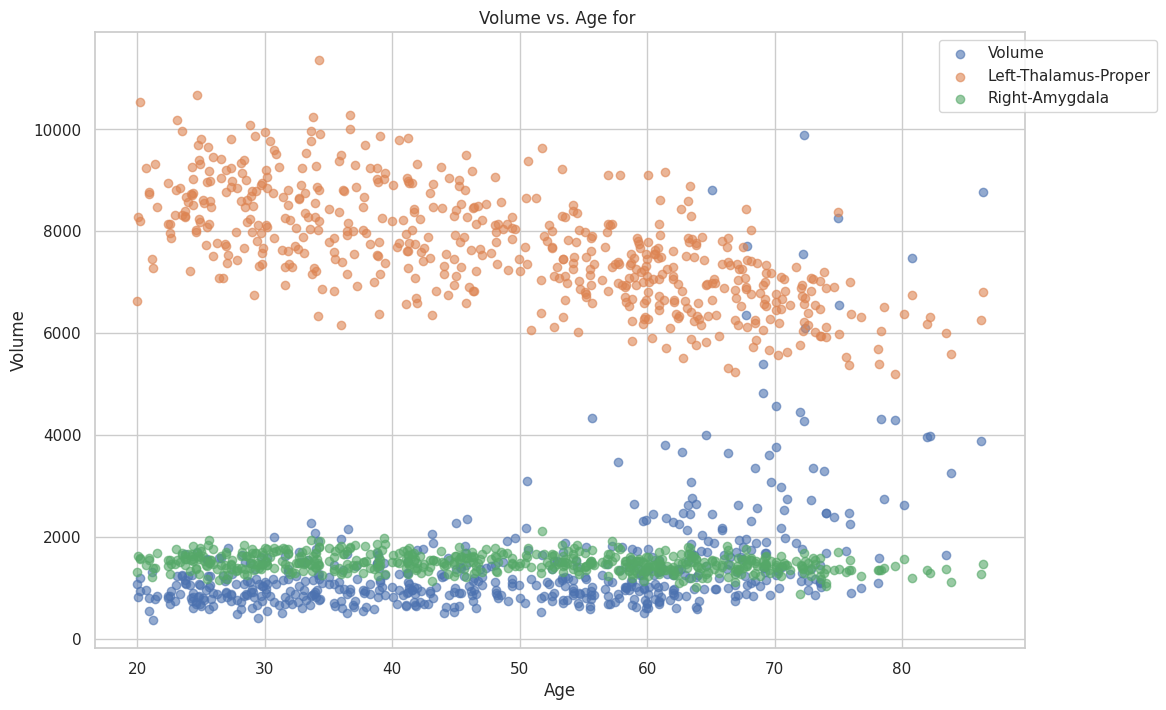

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設置圖形樣式
sns.set(style="whitegrid")

# 畫體積和年齡的點陣圖
plt.figure(figsize=(12, 8))
for region in age_correlation_df.index:
    plt.scatter(data['AGE'], data[region], label=region, alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Volume')
plt.title('Volume vs. Age for ')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_csv("/NFS/Wu/MRI/hw2/merged_W.csv")

# 删去缺失值
data = data.dropna()

# 選擇特徵及標籤
X = data[['Volume','Right-Amygdala']]  # 使用體積作特徵
y = data['SEX_ID']    # 性别作為標籤

# 分為訓練、測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用邏輯回歸模型訓練
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# 預測測試集
y_pred = log_reg_model.predict(X_test)

# 輸出结果
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"相關數據:\n{classification_report(y_test, y_pred)}")


Accuracy: 0.7256637168141593
相關數據:
              precision    recall  f1-score   support

           1       0.72      0.65      0.69        52
           2       0.73      0.79      0.76        61

    accuracy                           0.73       113
   macro avg       0.73      0.72      0.72       113
weighted avg       0.73      0.73      0.72       113



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

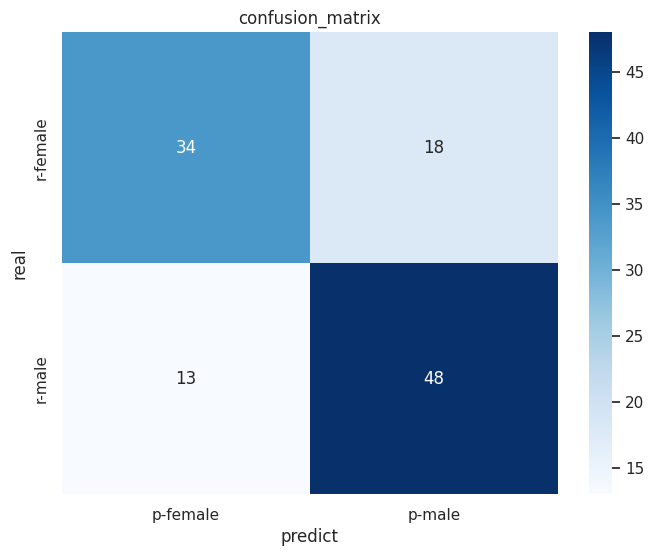

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)  # 計算混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['p-female', 'p-male'], yticklabels=['r-female', 'r-male'])
plt.title('confusion_matrix')
plt.xlabel('predict')
plt.ylabel('real')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = data[['Volume', 'Left-Thalamus-Proper']]
y = data['AGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

y_pred = lin_reg_model.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²值: {r2_score(y_test, y_pred)}")

results = pd.DataFrame({'實際年齡': y_test, '預測年齡': y_pred})
print(results)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

MSE: 128.2952129905929
R²值: 0.542869287697993
          實際年齡       預測年齡
250  45.752224  59.761472
521  39.383984  37.129200
268  33.921971  46.239124
55   26.272416  45.993267
549  34.056126  36.302171
..         ...        ...
88   38.902122  34.937838
320  72.594114  59.285123
357  59.835729  58.575527
33   37.733060  42.431521
244  63.044490  48.078267

[113 rows x 2 columns]


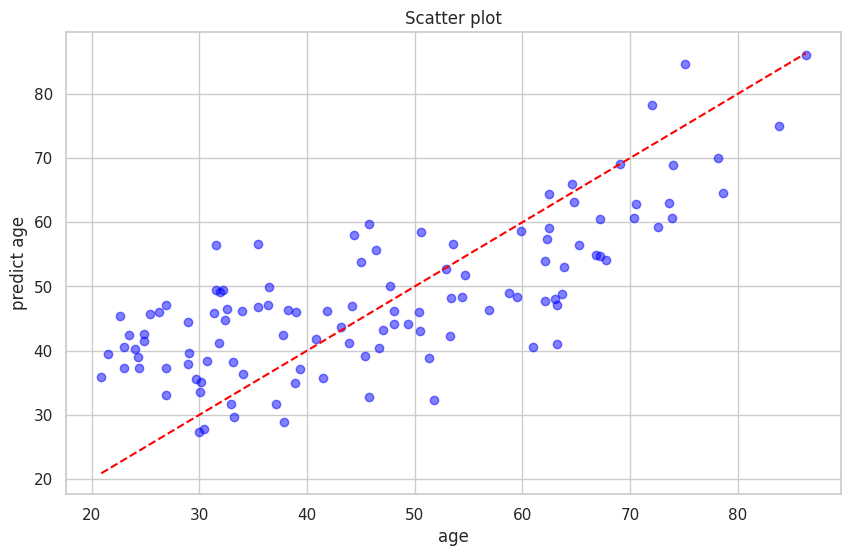

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--') 
plt.title('Scatter plot')
plt.xlabel('age')
plt.ylabel('predict age')
plt.grid(True)
plt.show()